## **ML models**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import randint
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import accuracy_score, log_loss, classification_report

In [3]:
data = pd.read_pickle("/content/drive/MyDrive/Fake News/pickels/44k_news")

In [4]:
data.head()

,id,subject,Labels,total
0,23711,Government News,Fake,obama fear mongering republican party unrecogn...
1,26364,politics,Fake,wow meghan mccain finished hateful hag view to...
2,39097,News,Fake,ben carson mistakenly make case vote trump dai...
3,25533,politics,Fake,nsc fulfill subpoena request susan rice unmask...
4,11401,left-news,Fake,busted hillary bill clinton massive money laun...


In [5]:
#converting labels from text to numerical form
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(data['Labels'])


data['Labels'] = labels
#Fake as 0
#True as 1

In [6]:
data.head()

,id,subject,Labels,total
0,23711,Government News,0,obama fear mongering republican party unrecogn...
1,26364,politics,0,wow meghan mccain finished hateful hag view to...
2,39097,News,0,ben carson mistakenly make case vote trump dai...
3,25533,politics,0,nsc fulfill subpoena request susan rice unmask...
4,11401,left-news,0,busted hillary bill clinton massive money laun...


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.total, data.Labels, test_size=0.25, random_state=0)

In [8]:
y_test.value_counts()

0    5893
1    5332
Name: Labels, dtype: int64

In [9]:
# Countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

text_vectorizer = CountVectorizer(ngram_range=(1,3), min_df=10, max_features=1000)

#Train
X_train_count_vec = text_vectorizer.fit_transform(X_train).toarray()
print("Train count vectorizer: ",X_train_count_vec.shape) 


#Test
X_test_count_vec=text_vectorizer.transform(X_test).toarray()
print("Test count vectorizer: ",X_test_count_vec.shape) 

Train count vectorizer:  (33673, 1000)
Test count vectorizer:  (11225, 1000)


In [10]:
#TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(ngram_range = (1,3), min_df=10, norm ='l2', max_features=1000)

#train
X_train_tfidf_vec = tfidf_vec.fit_transform(X_train).toarray()
print("Train Tfidf vectorizer: ",X_train_tfidf_vec.shape) 


#test
X_test_tfidf_vec = tfidf_vec.transform(X_test).toarray()
print("Test Tfidf vectorizer: ",X_test_tfidf_vec.shape) 


Train Tfidf vectorizer:  (33673, 1000)
Test Tfidf vectorizer:  (11225, 1000)


In [11]:
# Doc2Vec
from tqdm import tqdm
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
import numpy as np

def sentences_with_tags(document, tag_type):
  tagging_each= []

  for index, list_of_sentence in enumerate(document):
    tagging_each.append(TaggedDocument(list_of_sentence.split(),[tag_type + '_' + str(index)]))
  
  return tagging_each

#Train
X_train = sentences_with_tags(X_train, 'Train')

#Test
X_test = sentences_with_tags(X_test, 'Test')

#Combining both train and test to find vectors and then splitting them using their tags
combined_text_data = X_train + X_test

model_dbow = Doc2Vec(dm=0, vector_size=300, min_count=2)
model_dbow.build_vocab([words for words in tqdm(combined_text_data)])



100%|██████████| 44898/44898 [00:00<00:00, 2110998.70it/s]


In [12]:
#train model
model_dbow.train(utils.shuffle([w for w in tqdm(combined_text_data)]), total_examples = len(combined_text_data), epochs = 30)

100%|██████████| 44898/44898 [00:00<00:00, 2342586.72it/s]


In [13]:
#save doc2vec train model 
from gensim.test.utils import get_tmpfile

fpath = "/content/drive/MyDrive/Fake News/pickels/Doc2vec_Trained_Model"
model_dbow.save(fpath)


In [14]:
#load doc2vec model
from gensim.test.utils import get_tmpfile
from gensim.models import Doc2Vec

# fname = get_tmpfile("Doc2vec_trained_model")
fname = "/content/drive/MyDrive/Fake News/pickels/Doc2vec_Trained_Model"
model_dbow = Doc2Vec.load(fname)

In [15]:
# converting to vector form
def dbow_vectors(model, doc_size, vec_size , vec_type):
  vec = np.zeros((doc_size, vec_size))
  for i in range(0, doc_size):
    vec[i] = model.docvecs[vec_type + '_' + str(i)]
  return vec
  
#Train
X_train_dbow_vec = dbow_vectors(model_dbow, len(X_train), 300, 'Train')
print(X_train_dbow_vec.shape)

#Test
X_test_dbow_vec = dbow_vectors(model_dbow, len(X_test), 300, 'Test')
print(X_test_dbow_vec.shape)

(33673, 300)
(11225, 300)


In [16]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):

    #confusion matrix
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    C = confusion_matrix(test_y, predict_y)
    
    #Recall
    #divid each element of the confusion matrix with the sum of elements in that column
    A =(((C.T)/(C.sum(axis=1))).T)
    
    #Precision Matrix
    #divide each element of the confusion matrix with the sum of elements in that row
    B =(C/C.sum(axis=0))
    
    
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("green")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Logestic regression without hyperparameter tuning

In [17]:
def normal_logestic_regression(x_train, Y_train, x_test, Y_test,model,technique,hyperparameter):
  data = []
  
  log_reg = LogisticRegression(max_iter = 300)
  print(log_reg.get_params())
  log_reg.fit(x_train, Y_train)
  log_reg_prediction = log_reg.predict(x_test)
  Accuracy = accuracy_score(Y_test, log_reg_prediction)
  print('Accuracy: ', Accuracy)
  err=-cross_val_score(log_reg,x_test,Y_test,cv=10,scoring="neg_mean_squared_error",verbose=False).mean()
  Error = np.sqrt(err)
  print('Error: ',Error)

  print('\n')
  print(classification_report(Y_test, log_reg_prediction))

  pred = log_reg.predict_proba(x_train)
  pred_t = log_reg.predict_proba(x_test)
  print("*"*10,"LOG-LOSS","*"*10)

  
  print('log loss on train dataset : ', log_loss(Y_train, pred))
  print('log loss on test dataset : ', log_loss(Y_test, pred_t))

  data.append(model)
  data.append(technique)
  data.append(hyperparameter)
  data.append(Accuracy)
  data.append(Error)
  
  #plot confusion matrix
  plot_confusion_matrix(Y_test, log_reg_prediction)
  return data

********** BAG-OF-WORD **********
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 300, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy:  0.9941202672605791
Error:  0.08803387470408099


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5893
           1       0.99      0.99      0.99      5332

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

********** LOG-LOSS **********
log loss on train dataset :  0.0038478940278988934
log loss on test dataset :  0.029385641705048923


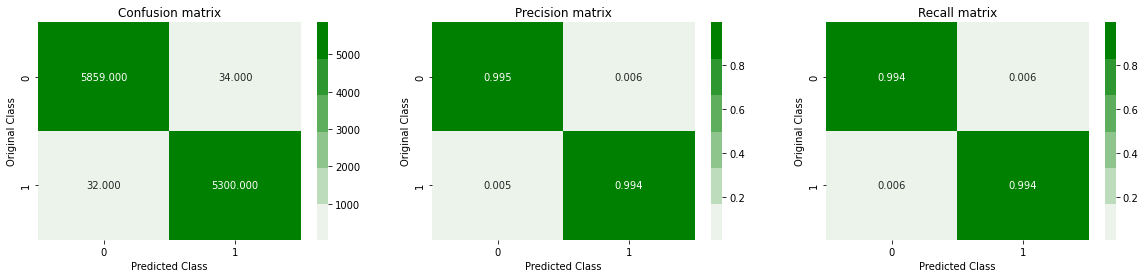




********** TF-IDF **********
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 300, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy:  0.9858351893095768
Error:  0.14314072625016455


              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5893
           1       0.98      0.99      0.99      5332

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

********** LOG-LOSS **********
log loss on train dataset :  0.059214225562051415
log loss on test dataset :  0.06655749949607334


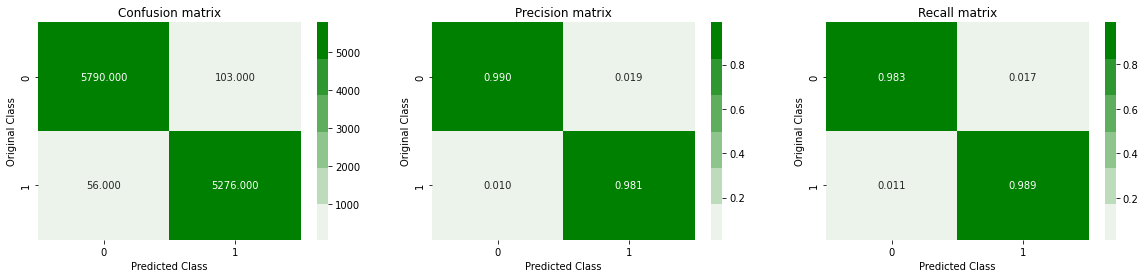




********** DOC2VEC **********
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 300, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy:  0.9902004454342984
Error:  0.10885489432628746


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5893
           1       0.99      0.99      0.99      5332

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

********** LOG-LOSS **********
log loss on train dataset :  0.01701522198506329
log loss on test dataset :  0.02859964401996434


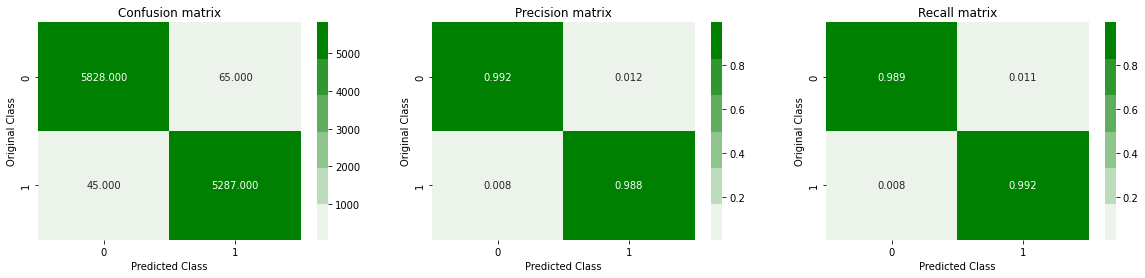

In [18]:
# For countvectorizer
print("*"*10,"BAG-OF-WORD","*"*10)
BOW = normal_logestic_regression(X_train_count_vec, y_train, X_test_count_vec, y_test,'Logestic Regression','BAG OF WORDS', 'No')
print("\n\n")

# For tfidfvectorizer
print("*"*10,"TF-IDF","*"*10)
TF_IDF = normal_logestic_regression(X_train_tfidf_vec, y_train, X_test_tfidf_vec, y_test,'Logestic Regression','TF-IDF','No')
print("\n\n")

#For Doc2vec
print("*"*10,"DOC2VEC","*"*10)
DOC2VEC = normal_logestic_regression(X_train_dbow_vec, y_train, X_test_dbow_vec, y_test,'Logestic Regression','DOC2VEC','No')



In [19]:
#storing result to dataframe
dt = [BOW,TF_IDF,DOC2VEC]
df1 = pd.DataFrame(dt,columns=['Model','Technique','Hyperparameter-Tuning','Accuracy','Error'])
summary_df = pd.DataFrame(df1,columns=['Model','Technique','Hyperparameter-Tuning','Accuracy','Error'])
df1

,Model,Technique,Hyperparameter-Tuning,Accuracy,Error
0,Logestic Regression,BAG OF WORDS,No,0.994120,0.088034
1,Logestic Regression,TF-IDF,No,0.985835,0.143141
2,Logestic Regression,DOC2VEC,No,0.990200,0.108855


### Logestic Regression with Hyperparameter tuning

In [ ]:
def bestparam_logestic_regression(x_train, Y_train, x_test, Y_test,model,technique,hyperparameter):
  # initialise all hyperparameter which is need to be regularize
  data = []
  hyperparam = {'C': [10 ** x for x in range(-5, 2)] }
  gridsearch = GridSearchCV(LogisticRegression(), hyperparam, cv = 3, verbose = 0,return_train_score=True)
  grid = gridsearch.fit(x_train, Y_train)

  #Getting best values of parameter 
  print('Best parameters')
  print("gridsearch: ",grid.best_params_)
  print('\n\n')

  # putting best parameter to our model
  log_reg = LogisticRegression(**grid.best_params_,max_iter= 300)
  log_reg.fit(x_train, Y_train)
  
  sig_cal = CalibratedClassifierCV(log_reg, method="sigmoid")
  sig_cal.fit(x_train, Y_train)
  
  predic_test = sig_cal.predict(x_test)
  Accuracy = accuracy_score(Y_test, predic_test)
  print('Accuracy: ', Accuracy)

  err=-cross_val_score(sig_cal,x_test,Y_test,cv=10,scoring="neg_mean_squared_error",verbose=False).mean()
  Error = np.sqrt(err)
  print('Error: ',Error)
  print('\n')
  
  data.append(model)
  data.append(technique)
  data.append(hyperparameter)
  data.append(Accuracy)
  data.append(Error)

  test_scores = grid.cv_results_['mean_test_score']
  train_scores = grid.cv_results_['mean_train_score'] 

  #plot graph for train and test score
  plt.plot(test_scores,color='blue', marker='o',label='test')
  plt.plot(train_scores,color='red', marker='o',label='train')
  plt.legend(loc='best')
  plt.show()


  log_reg_predic_train = sig_cal.predict_proba(x_train)
  print("The train log loss is:",log_loss(Y_train, log_reg_predic_train, labels=log_reg.classes_, eps=1e-15))
  log_reg_predic_test = sig_cal.predict_proba(x_test)
  print("The test log loss is:",log_loss(Y_test, log_reg_predic_test, labels=log_reg.classes_, eps=1e-15))
  print('\n\n')
  print(classification_report(Y_test, predic_test))
  print('\n\n')
  predicted_y =np.argmax(log_reg_predic_test,axis=1)
  print("Total number of data points :", len(predicted_y))
  print('\n\n')
  
  #plot confusion matrix
  plot_confusion_matrix(Y_test, predic_test)
  print('\n\n')

  #plot roc curve
  from sklearn.metrics import roc_curve, auc
  fpr,tpr,ths = roc_curve(Y_test,predic_test)
  auc_sc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic with test data')
  plt.legend()
  plt.show()

  return data

********** BAG-OF-WORD **********


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Best parameters
gridsearch:  {'C': 0.1}



Accuracy:  0.9939420935412027
Error:  0.08953961567126707




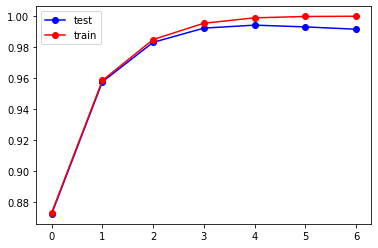

The train log loss is: 0.06367511690024655
The test log loss is: 0.07114572110363777



              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5893
           1       0.99      1.00      0.99      5332

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225




Total number of data points : 11225





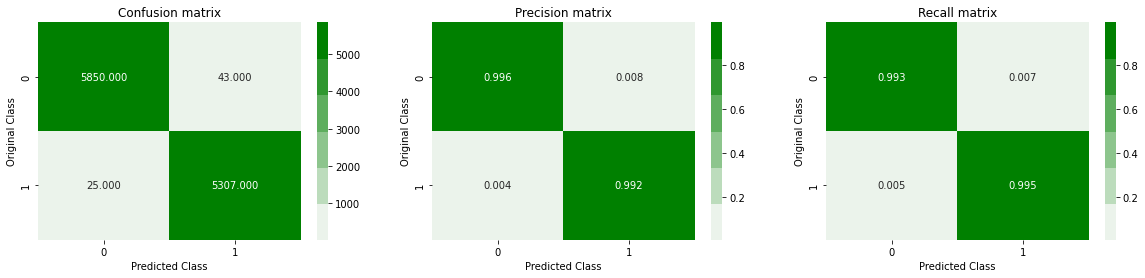

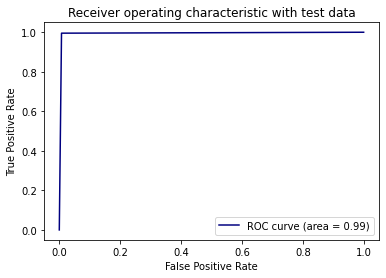

In [ ]:
# For countvectorizer
print("*"*10,"BAG-OF-WORD","*"*10)
BOW = bestparam_logestic_regression(X_train_count_vec, y_train, X_test_count_vec, y_test,'Logestic Regression','BAG OF WORDS', 'Yes')
print("\n\n")



********** TF-IDF **********


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Best parameters
gridsearch:  {'C': 10}



Accuracy:  0.9903786191536749
Error:  0.1182632793402163




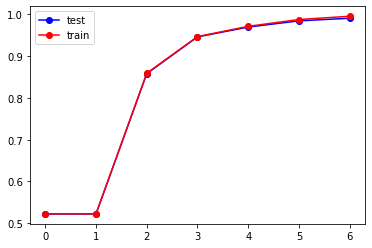

The train log loss is: 0.016746126758149744
The test log loss is: 0.029735838196539008



              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5893
           1       0.99      0.99      0.99      5332

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225




Total number of data points : 11225





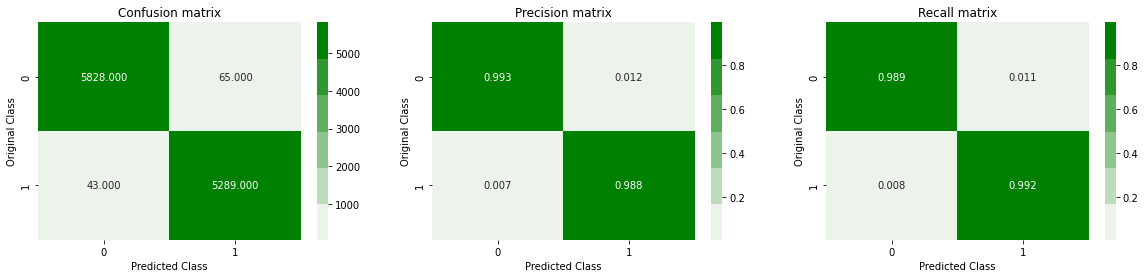

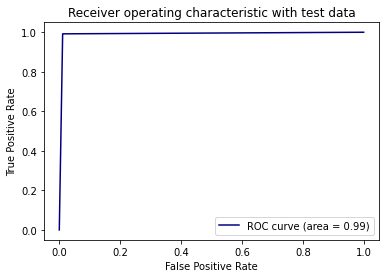

In [ ]:
# For tfidfvectorizer
print("*"*10,"TF-IDF","*"*10)
TF_IDF = bestparam_logestic_regression(X_train_tfidf_vec, y_train, X_test_tfidf_vec, y_test,'Logestic Regression','TF-IDF','Yes')
print("\n\n")



********** DOC2VEC **********
Best parameters
gridsearch:  {'C': 0.1}



Accuracy:  0.9914476614699332
Error:  0.10425295392994251




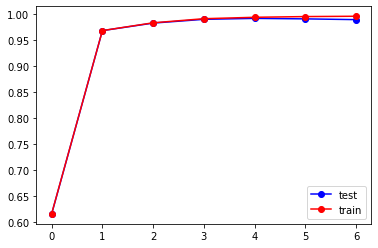

The train log loss is: 0.020030952082055634
The test log loss is: 0.026612126189055965



              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5893
           1       0.99      0.99      0.99      5332

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225




Total number of data points : 11225





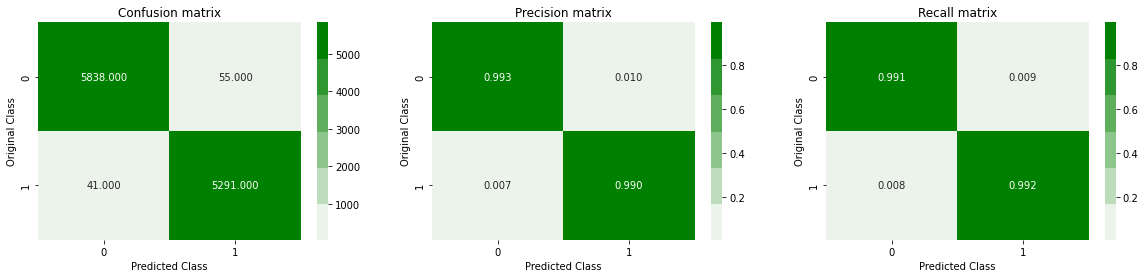

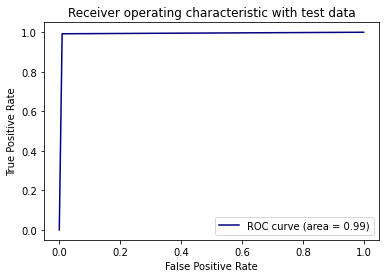

In [ ]:
# For Doc2vec
print("*"*10,"DOC2VEC","*"*10)
DOC2VEC = bestparam_logestic_regression(X_train_dbow_vec, y_train, X_test_dbow_vec, y_test,'Logestic Regression','DOC2VEC','Yes')

In [ ]:
#storing result to dataframe
dt = [BOW,TF_IDF,DOC2VEC]
df2 = pd.DataFrame(dt,columns=['Model','Technique','Hyperparameter-Tuning','Accuracy','Error'])
summary_df = summary_df.append(df2, ignore_index = True)
df2

,Model,Technique,Hyperparameter-Tuning,Accuracy,Error
0,Logestic Regression,BAG OF WORDS,Yes,0.993942,0.089540
1,Logestic Regression,TF-IDF,Yes,0.990379,0.118263
2,Logestic Regression,DOC2VEC,Yes,0.991448,0.104253


### **Naive Bayes**

In [ ]:
def gaussian_naive_bayes(x_train, Y_train, x_test, Y_test,model,technique,hyperparameter):
  data = []
  naive_bayes = GaussianNB()
  print(naive_bayes.get_params())
  naive_bayes.fit(x_train, Y_train)
  naive_bayes_prediction = naive_bayes.predict(x_test)
  Accuracy = accuracy_score(Y_test, naive_bayes_prediction)
  print('Accuracy: ', Accuracy)

  err=-cross_val_score(naive_bayes,x_test,Y_test,cv=10,scoring="neg_mean_squared_error",verbose=False).mean()
  Error = np.sqrt(err)
  print('Error: ',Error)

  print('\n')

  print(classification_report(Y_test, naive_bayes_prediction))

  pred = naive_bayes.predict_proba(x_train)
  pred_t = naive_bayes.predict_proba(x_test)
  print("*"*10,"LOG-LOSS","*"*10)
  print('log loss on train dataset : ', log_loss(Y_train, pred))
  print('log loss on test dataset : ', log_loss(Y_test, pred_t))

  data.append(model)
  data.append(technique)
  data.append(hyperparameter)
  data.append(Accuracy)
  data.append(Error)

  #plot confusion matrix
  plot_confusion_matrix(Y_test, naive_bayes_prediction)

  print('\n\n')

  # plot ROC curve
  from sklearn.metrics import roc_curve, auc
  fpr,tpr,ths = roc_curve(Y_test,naive_bayes_prediction)
  auc_sc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic with test data')
  plt.legend()
  plt.show()

  return data

********** BAG-OF-WORD **********
{'priors': None, 'var_smoothing': 1e-09}
Accuracy:  0.901380846325167
Error:  0.30424150367373365


              precision    recall  f1-score   support

           0       0.95      0.86      0.90      5893
           1       0.86      0.95      0.90      5332

    accuracy                           0.90     11225
   macro avg       0.90      0.90      0.90     11225
weighted avg       0.91      0.90      0.90     11225

********** LOG-LOSS **********
log loss on train dataset :  2.493888922489051
log loss on test dataset :  2.7421837604925394


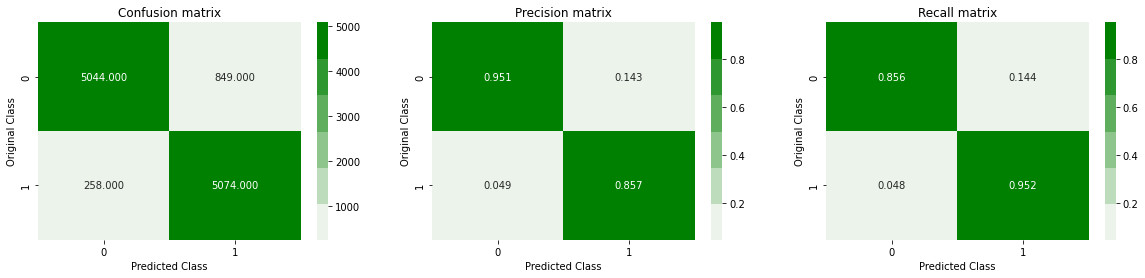

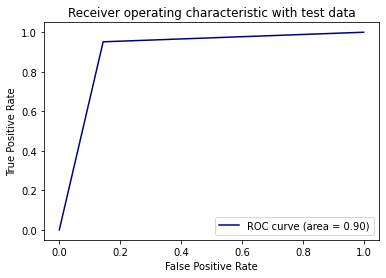




********** TF-IDF **********
{'priors': None, 'var_smoothing': 1e-09}
Accuracy:  0.9375501113585746
Error:  0.24847028753909334


              precision    recall  f1-score   support

           0       0.95      0.93      0.94      5893
           1       0.92      0.95      0.94      5332

    accuracy                           0.94     11225
   macro avg       0.94      0.94      0.94     11225
weighted avg       0.94      0.94      0.94     11225

********** LOG-LOSS **********
log loss on train dataset :  1.8277935413696336
log loss on test dataset :  1.9502564673392213


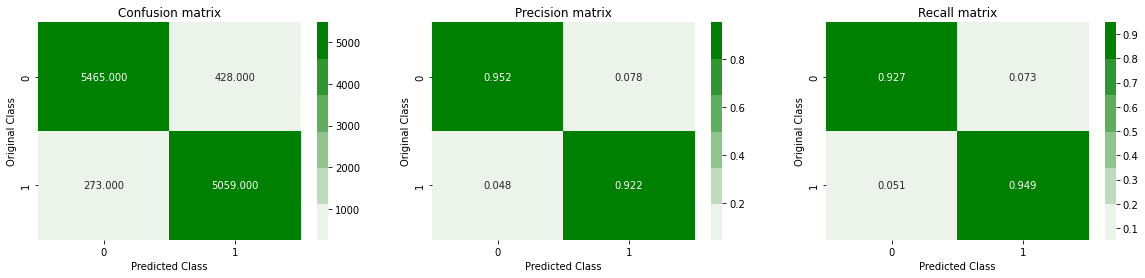

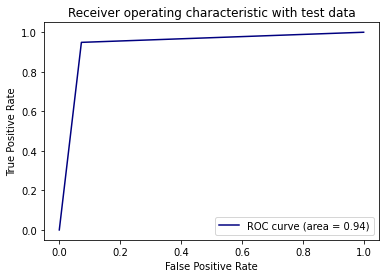




********** DOC2VEC **********
{'priors': None, 'var_smoothing': 1e-09}
Accuracy:  0.9264142538975502
Error:  0.2715967736722415


              precision    recall  f1-score   support

           0       0.94      0.92      0.93      5893
           1       0.92      0.93      0.92      5332

    accuracy                           0.93     11225
   macro avg       0.93      0.93      0.93     11225
weighted avg       0.93      0.93      0.93     11225

********** LOG-LOSS **********
log loss on train dataset :  0.29126840513017166
log loss on test dataset :  0.29780781991834704


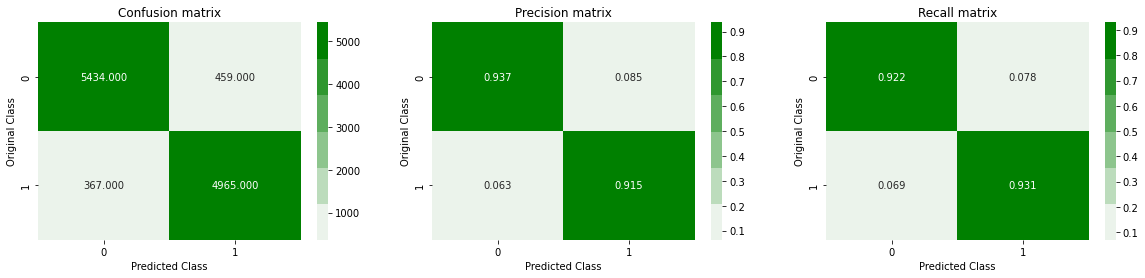

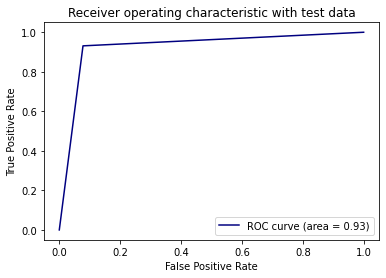

In [ ]:
# For countvectorizer
print("*"*10,"BAG-OF-WORD","*"*10)
BOW = gaussian_naive_bayes(X_train_count_vec, y_train, X_test_count_vec, y_test,'Naive Bayes','BAG OF WORDS', 'No')
print("\n\n")

# For tfidfvectorizer
print("*"*10,"TF-IDF","*"*10)
TF_IDF = gaussian_naive_bayes(X_train_tfidf_vec, y_train, X_test_tfidf_vec, y_test,'Naive Bayes','TF-IDF','No')
print("\n\n")

#For Doc2vec
print("*"*10,"DOC2VEC","*"*10)
DOC2VEC = gaussian_naive_bayes(X_train_dbow_vec, y_train, X_test_dbow_vec, y_test,'Naive Bayes','DOC2VEC','No')


In [ ]:
#storing result to dataframe
dt = [BOW,TF_IDF,DOC2VEC]
df3 = pd.DataFrame(dt,columns=['Model','Technique','Hyperparameter-Tuning','Accuracy','Error'])
summary_df = summary_df.append(df3, ignore_index = True)
df3

,Model,Technique,Hyperparameter-Tuning,Accuracy,Error
0,Naive Bayes,BAG OF WORDS,No,0.901381,0.304242
1,Naive Bayes,TF-IDF,No,0.937550,0.248470
2,Naive Bayes,DOC2VEC,No,0.926414,0.271597


### **Decision Tree without hyperparameter tuning**

In [ ]:
def decision_trees(x_train, Y_train, x_test, Y_test,model,technique,hyperparameter):
  data = []
  dec_tree = DecisionTreeClassifier()
  print(dec_tree.get_params())
  dec_tree.fit(x_train, Y_train)
  dec_tree_prediction = dec_tree.predict(x_test)
  Accuracy = accuracy_score(Y_test, dec_tree_prediction)
  print('Accuracy: ',Accuracy )

  err=-cross_val_score(dec_tree,x_test,Y_test,cv=10,scoring="neg_mean_squared_error",verbose=False).mean()
  Error = np.sqrt(err)
  print('Error: ',Error)
  print('\n')

  data.append(model)
  data.append(technique)
  data.append(hyperparameter)
  data.append(Accuracy)
  data.append(Error)

  print(classification_report(Y_test, dec_tree_prediction))

  pred = dec_tree.predict_proba(x_train)
  pred_t = dec_tree.predict_proba(x_test)
  print("*"*10,"LOG-LOSS","*"*10)
  print('log loss on train dataset : ', log_loss(Y_train, pred))
  print('log loss on test dataset : ', log_loss(Y_test, pred_t))
  print('\n\n')
  #plot confusion matrix
  plot_confusion_matrix(Y_test, dec_tree_prediction)
  print('\n\n')

  return data

********** BAG-OF-WORD **********
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Accuracy:  0.9933184855233853
Error:  0.09199615770203635


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5893
           1       0.99      0.99      0.99      5332

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

********** LOG-LOSS **********
log loss on train dataset :  9.992007221626413e-16
log loss on test dataset :  0.23077133448715473





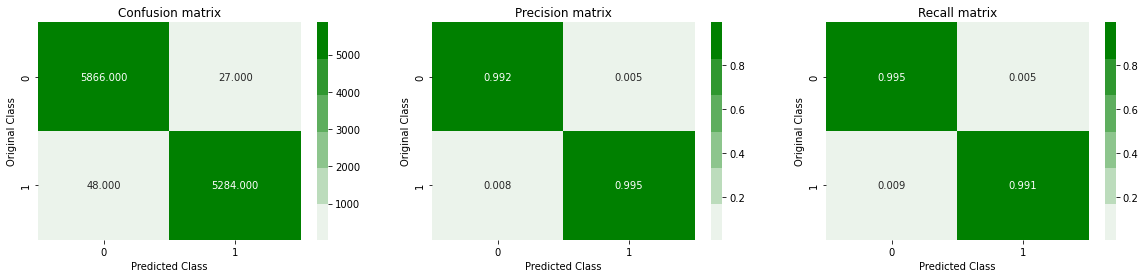







********** TF-IDF **********
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Accuracy:  0.9952783964365256
Error:  0.0929594900301529


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5893
           1       0.99      1.00      1.00      5332

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225

********** LOG-LOSS **********
log loss on train dataset :  9.992007221626413e-16
log loss on test dataset :  0.16307840970425633





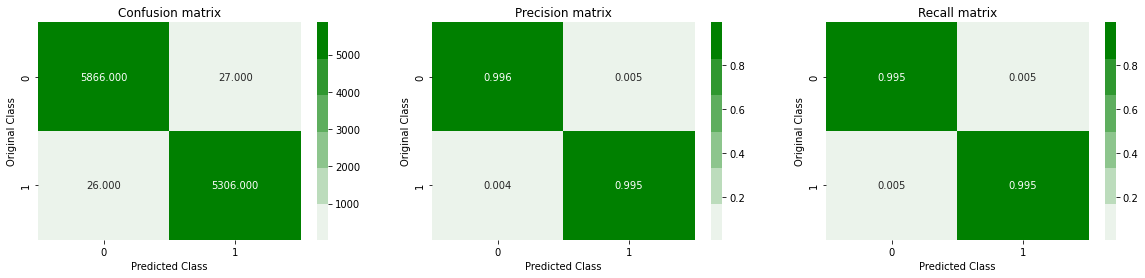







********** DOC2VEC **********
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Accuracy:  0.7830734966592428
Error:  0.4996230342944295


              precision    recall  f1-score   support

           0       0.79      0.80      0.79      5893
           1       0.77      0.77      0.77      5332

    accuracy                           0.78     11225
   macro avg       0.78      0.78      0.78     11225
weighted avg       0.78      0.78      0.78     11225

********** LOG-LOSS **********
log loss on train dataset :  9.992007221626413e-16
log loss on test dataset :  7.492375993016259





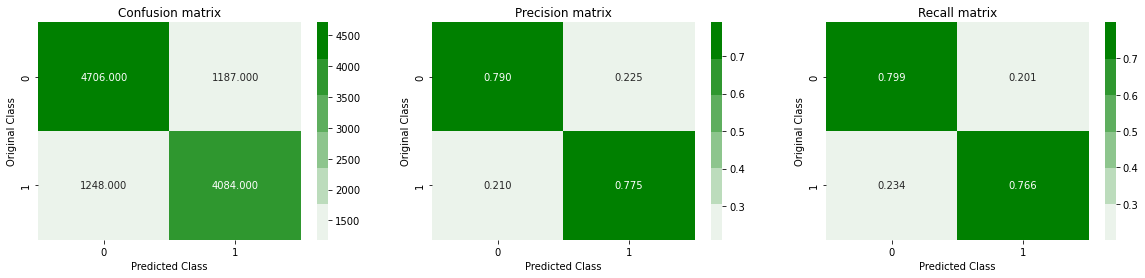

In [ ]:
# For countvectorizer
print("*"*10,"BAG-OF-WORD","*"*10)
BOW = decision_trees(X_train_count_vec, y_train, X_test_count_vec, y_test,'Decision Tree','BAG OF WORDS', 'No')
print("\n\n")

# For tfidfvectorizer
print("*"*10,"TF-IDF","*"*10)
TF_IDF = decision_trees(X_train_tfidf_vec, y_train, X_test_tfidf_vec, y_test,'Decision Tree','TF-IDF','No')
print("\n\n")

# For Doc2vec
print("*"*10,"DOC2VEC","*"*10)
DOC2VEC = decision_trees(X_train_dbow_vec, y_train, X_test_dbow_vec, y_test,'Decision Tree','DOC2VEC','No')


In [ ]:
#storing result to dataframe
dt = [BOW,TF_IDF,DOC2VEC]
df4 = pd.DataFrame(dt,columns=['Model','Technique','Hyperparameter-Tuning','Accuracy','Error'])
summary_df = summary_df.append(df4, ignore_index = True)
df4

,Model,Technique,Hyperparameter-Tuning,Accuracy,Error
0,Decision Tree,BAG OF WORDS,No,0.993318,0.091996
1,Decision Tree,TF-IDF,No,0.995278,0.092959
2,Decision Tree,DOC2VEC,No,0.783073,0.499623


### **Decision Tree with hyperparameter tuning**

In [ ]:
def bestparam_decision_trees(x_train, Y_train, x_test, Y_test,model,technique,hyperparameter):
  # initialise all hyperparameter which is need to be regularize
  data = []
  hyperparam = {'min_samples_leaf': [1,7], 'criterion': ['gini', 'entropy'], 'max_depth': [3,7,None]}
  gridsearch = GridSearchCV(DecisionTreeClassifier(), hyperparam, cv = 3, verbose = 3, return_train_score=True, n_jobs=-1)
  grid = gridsearch.fit(x_train, Y_train)

  #Getting best values of parameter 
  print('\n\n')
  print('Best parameters')
  print("gridsearch: ",grid.best_params_)
  print('\n\n')

  dec_trees = DecisionTreeClassifier(**grid.best_params_)
  dec_trees.fit(x_train, Y_train)

  sig_cal = CalibratedClassifierCV(dec_trees, method="sigmoid")
  sig_cal.fit(x_train, Y_train)

  predic_test = sig_cal.predict(x_test)
  Accuracy = accuracy_score(Y_test, predic_test)
  print('Accuracy: ', Accuracy)

  err=-cross_val_score(sig_cal,x_test,Y_test,cv=10,scoring="neg_mean_squared_error",verbose=False).mean()
  Error = np.sqrt(err)
  print('Error: ',Error)
  print('\n')

  data.append(model)
  data.append(technique)
  data.append(hyperparameter)
  data.append(Accuracy)
  data.append(Error)

  test_scores = grid.cv_results_['mean_test_score']
  train_scores = grid.cv_results_['mean_train_score'] 
 
  #plot graph for train and test score
  plt.plot(test_scores,color='blue', marker='o',label='test')
  plt.plot(train_scores,color='red', marker='o',label='train')
  plt.legend(loc='best')
  plt.show()
  
  dec_trees_predic_train = sig_cal.predict_proba(x_train)
  print("The train log loss is:",log_loss(Y_train, dec_trees_predic_train))
  dec_trees_predic_test = sig_cal.predict_proba(x_test)
  print("The test log loss is:",log_loss(Y_test, dec_trees_predic_test))
  print('\n\n')
  print(classification_report(Y_test, predic_test))
  print('\n\n')
  predicted_y =np.argmax(dec_trees_predic_test,axis=1)
  print("Total number of data points :", len(predicted_y))
  print('\n\n')
  
  # plot confusion matrix
  plot_confusion_matrix(Y_test, predic_test)

  print('\n\n')
  # plot roc curve
  from sklearn.metrics import roc_curve, auc
  fpr,tpr,ths = roc_curve(Y_test,predic_test)
  auc_sc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic with test data')
  plt.legend()
  plt.show()

  return data

********** BAG-OF-WORD **********
Fitting 3 folds for each of 12 candidates, totalling 36 fits



Best parameters
gridsearch:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1}



Accuracy:  0.9942984409799555
Error:  0.07551077810555669




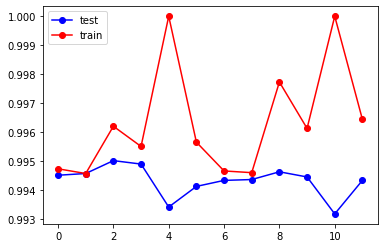

The train log loss is: 0.021422924621695198
The test log loss is: 0.029968178436323278



              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5893
           1       0.99      1.00      0.99      5332

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225




Total number of data points : 11225





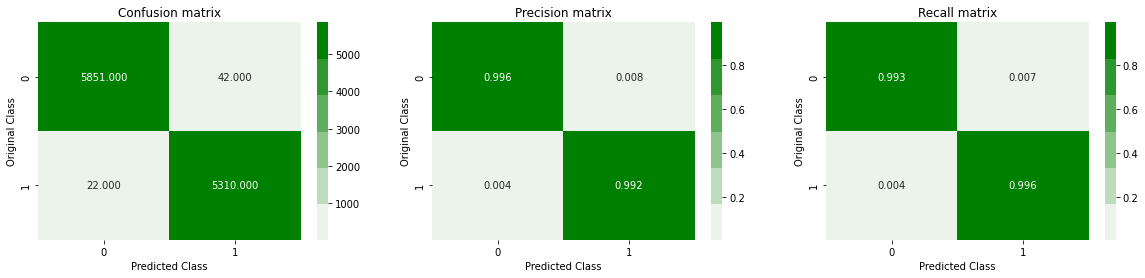

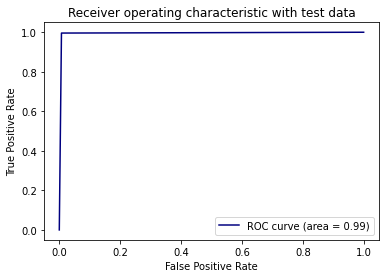

In [ ]:
# For countvectorizer
print("*"*10,"BAG-OF-WORD","*"*10)
BOW = bestparam_decision_trees(X_train_count_vec, y_train, X_test_count_vec, y_test,'Decision Tree','BAG OF WORDS', 'Yes')
print("\n\n")



********** TF-IDF **********
Fitting 3 folds for each of 12 candidates, totalling 36 fits



Best parameters
gridsearch:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 7}



Accuracy:  0.9951893095768374
Error:  0.08064354735456687




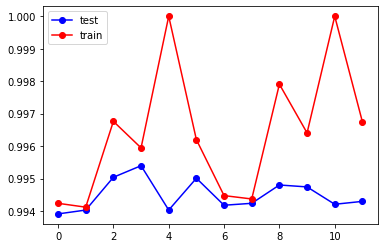

The train log loss is: 0.019812570552515396
The test log loss is: 0.02667662097733821



              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5893
           1       0.99      1.00      0.99      5332

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225




Total number of data points : 11225





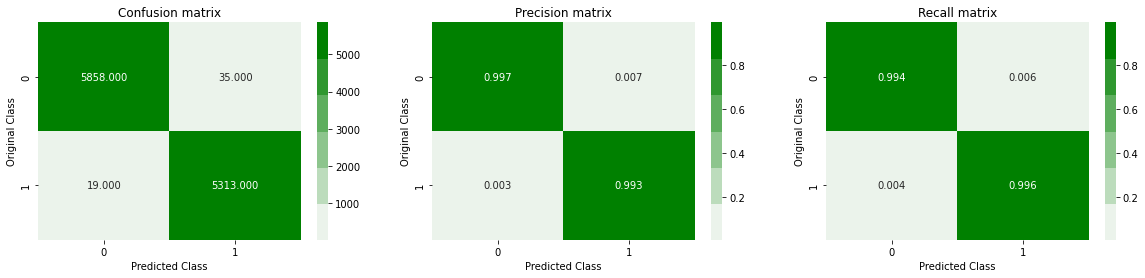

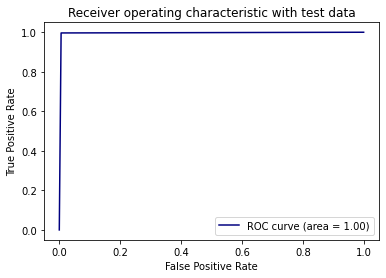

In [ ]:
# For tfidfvectorizer
print("*"*10,"TF-IDF","*"*10)
TF_IDF = bestparam_decision_trees(X_train_tfidf_vec, y_train, X_test_tfidf_vec, y_test,'Decision Tree','TF-IDF','Yes')
print("\n\n")



********** DOC2VEC **********
Fitting 3 folds for each of 12 candidates, totalling 36 fits



Best parameters
gridsearch:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1}



Accuracy:  0.8641425389755011
Error:  0.40520063115430865




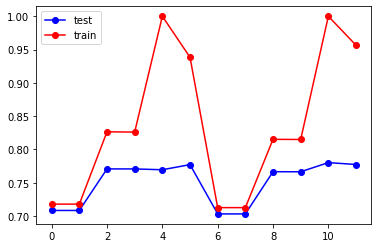

The train log loss is: 0.2781140279382926
The test log loss is: 0.4422283971157733



              precision    recall  f1-score   support

           0       0.87      0.88      0.87      5893
           1       0.86      0.85      0.86      5332

    accuracy                           0.86     11225
   macro avg       0.86      0.86      0.86     11225
weighted avg       0.86      0.86      0.86     11225




Total number of data points : 11225





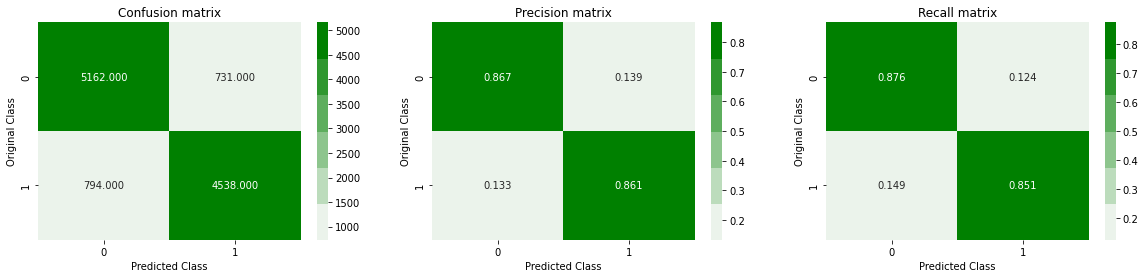

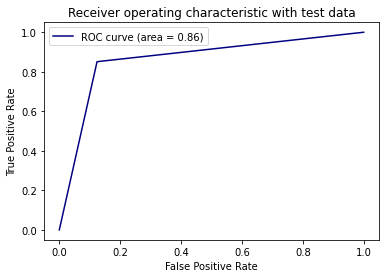

In [ ]:
# For Doc2vec
print("*"*10,"DOC2VEC","*"*10)
DOC2VEC = bestparam_decision_trees(X_train_dbow_vec, y_train, X_test_dbow_vec, y_test,'Decision Tree','DOC2VEC','Yes')

In [ ]:
#storing result to dataframe
dt = [BOW,TF_IDF,DOC2VEC]
df5 = pd.DataFrame(dt,columns=['Model','Technique','Hyperparameter-Tuning','Accuracy','Error'])
summary_df = summary_df.append(df5, ignore_index = True)
df5

,Model,Technique,Hyperparameter-Tuning,Accuracy,Error
0,Decision Tree,BAG OF WORDS,Yes,0.994298,0.075511
1,Decision Tree,TF-IDF,Yes,0.995189,0.080644
2,Decision Tree,DOC2VEC,Yes,0.864143,0.405201


### **Random forest without hyperparameter tuning**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(x_train, Y_train, x_test, Y_test,model,technique,hyperparameter):
  data = []
  rand_for = RandomForestClassifier(random_state =1)
  print(rand_for.get_params())
  rand_for.fit(x_train, Y_train)
  rand_for_prediction = rand_for.predict(x_test)
  Accuracy = accuracy_score(Y_test, rand_for_prediction)
  print('Accuracy: ', Accuracy)

  err=-cross_val_score(rand_for,x_test,Y_test,cv=10,scoring="neg_mean_squared_error",verbose=False).mean()
  Error = np.sqrt(err)
  print('Error: ',Error)
  print('\n')

  print(classification_report(Y_test, rand_for_prediction))

  data.append(model)
  data.append(technique)
  data.append(hyperparameter)
  data.append(Accuracy)
  data.append(Error)


  pred = rand_for.predict_proba(x_train)
  pred_t = rand_for.predict_proba(x_test)
  print("*"*10,"LOG-LOSS","*"*10)
  print('log loss on train dataset : ', log_loss(Y_train, pred))
  print('log loss on test dataset : ', log_loss(Y_test, pred_t))
  print('\n\n')
  #plot confusion matrix
  plot_confusion_matrix(Y_test, rand_for_prediction)
  print('\n\n')

  return data

********** BAG-OF-WORD **********
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
Accuracy:  0.9967037861915368
Error:  0.06674146561849867


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5893
           1       1.00      1.00      1.00      5332

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225

********** LOG-LOSS **********
log loss on train dataset :  0.02169620892496276
log loss on test dataset :  0.06426957249399205





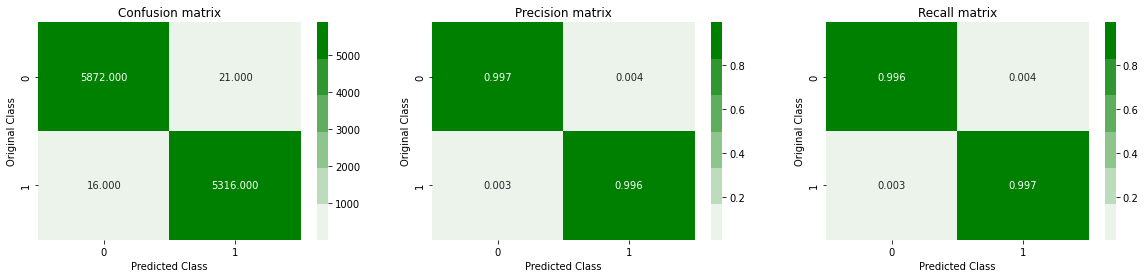







********** TF-IDF **********
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
Accuracy:  0.9967037861915368
Error:  0.06806260076526574


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5893
           1       1.00      1.00      1.00      5332

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225

********** LOG-LOSS **********
log loss on train dataset :  0.02222748262246032
log loss on test dataset :  0.06431391214652017





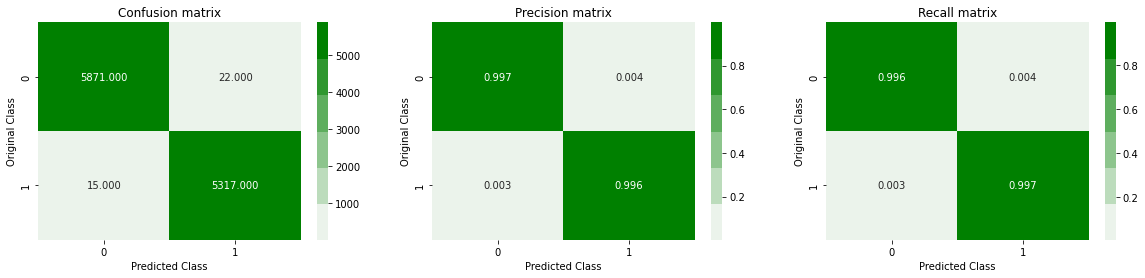







********** DOC2VEC **********
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
Accuracy:  0.9599109131403119
Error:  0.23368998649673092


              precision    recall  f1-score   support

           0       0.95      0.98      0.96      5893
           1       0.97      0.94      0.96      5332

    accuracy                           0.96     11225
   macro avg       0.96      0.96      0.96     11225
weighted avg       0.96      0.96      0.96     11225

********** LOG-LOSS **********
log loss on train dataset :  0.10560296511930613
log loss on test dataset :  0.3284693706456876





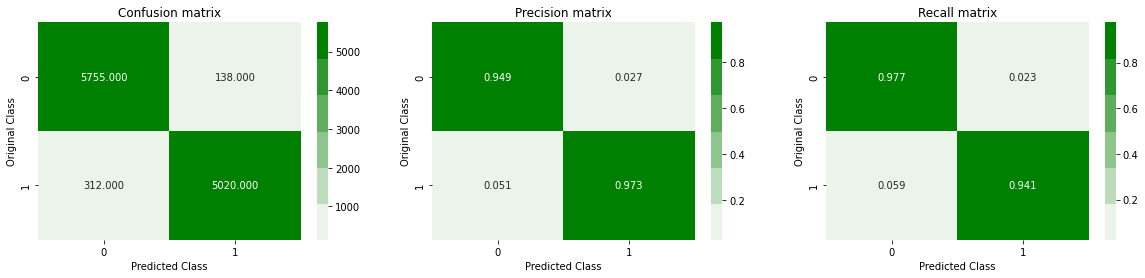

In [ ]:
# For countvectorizer
print("*"*10,"BAG-OF-WORD","*"*10)
BOW = random_forest(X_train_count_vec, y_train, X_test_count_vec, y_test,'Random Forest','BAG OF WORDS', 'No')
print("\n\n")

# For tfidfvectorizer
print("*"*10,"TF-IDF","*"*10)
TF_IDF = random_forest(X_train_tfidf_vec, y_train, X_test_tfidf_vec, y_test,'Random Forest','TF-IDF','No')
print("\n\n")

# For Doc2vec
print("*"*10,"DOC2VEC","*"*10)
DOC2VEC = random_forest(X_train_dbow_vec, y_train, X_test_dbow_vec, y_test,'Random Forest','DOC2VEC','No')


In [ ]:
#storing result to dataframe
dt = [BOW,TF_IDF,DOC2VEC]
df6 = pd.DataFrame(dt,columns=['Model','Technique','Hyperparameter-Tuning','Accuracy','Error'])
summary_df = summary_df.append(df6, ignore_index = True)
df6

,Model,Technique,Hyperparameter-Tuning,Accuracy,Error
0,Random Forest,BAG OF WORDS,No,0.996704,0.066741
1,Random Forest,TF-IDF,No,0.996704,0.068063
2,Random Forest,DOC2VEC,No,0.959911,0.233690


### **Random forest with hyperparameter tuning**

In [ ]:
def bestparam_random_forest(x_train, Y_train, x_test, Y_test,model,technique,hyperparameter):
  # initialise all hyperparameter which is need to be regularize
  # as we already find out hyperparam and now giving only those value which we already got so to reduce the time for execution when executing again.
  data = []
  hyperparam = {'n_estimators': [100,500], 'max_depth': [5,15,25], 
                'min_samples_split': [2,5],  'min_samples_leaf': [1, 3] }

  gridsearch = GridSearchCV(RandomForestClassifier(random_state =1), hyperparam, cv = 3, verbose = 3, return_train_score=True, n_jobs=-1)
  grid = gridsearch.fit(x_train, Y_train)

  #Getting best values of parameter 
  print('\n\n')
  print('Best parameters')
  print("gridsearch: ",grid.best_params_)
  print('\n\n')

  rand_for = RandomForestClassifier(**grid.best_params_, random_state=1)
  rand_for.fit(x_train, Y_train)

  sig_cal = CalibratedClassifierCV(rand_for, method="sigmoid")
  sig_cal.fit(x_train, Y_train)

  predic_test = sig_cal.predict(x_test)
  Accuracy = accuracy_score(Y_test, predic_test)
  print('Accuracy: ', Accuracy)

  err=-cross_val_score(sig_cal,x_test,Y_test,cv=10,scoring="neg_mean_squared_error",verbose=False).mean()
  Error = np.sqrt(err)
  print('Error: ',Error)
  print('\n')

  data.append(model)
  data.append(technique)
  data.append(hyperparameter)
  data.append(Accuracy)
  data.append(Error)

  test_scores = grid.cv_results_['mean_test_score']
  train_scores = grid.cv_results_['mean_train_score'] 
 
  #plot graph for train and test score
  plt.plot(test_scores,color='blue', marker='o',label='test')
  plt.plot(train_scores,color='red', marker='o',label='train')
  plt.legend(loc='best')
  plt.show()

  rand_for_predic_train = sig_cal.predict_proba(x_train)
  print("The train log loss is:",log_loss(Y_train, rand_for_predic_train))
  rand_for_predic_test = sig_cal.predict_proba(x_test)
  print("The test log loss is:",log_loss(Y_test, rand_for_predic_test))
  print('\n\n')
  print(classification_report(Y_test, predic_test))
  print('\n\n')
  predicted_y =np.argmax(rand_for_predic_test,axis=1)
  print("Total number of data points :", len(predicted_y))
  print('\n\n')
  #Plot Confusion matrix
  plot_confusion_matrix(Y_test, predic_test)

  print('\n\n')
  #plot roc curve
  from sklearn.metrics import roc_curve, auc
  fpr,tpr,ths = roc_curve(Y_test,predic_test)
  auc_sc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic with test data')
  plt.legend()
  plt.show()

  return data

********** BAG-OF-WORD **********
Fitting 3 folds for each of 24 candidates, totalling 72 fits



Best parameters
gridsearch:  {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}



Accuracy:  0.9967037861915368
Error:  0.06401497476408204




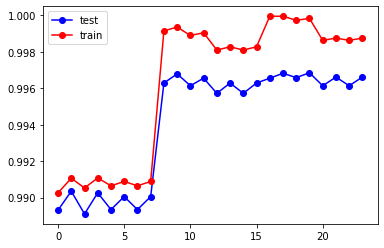

The train log loss is: 0.002022773577564962
The test log loss is: 0.012529897276087996



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5893
           1       1.00      1.00      1.00      5332

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225




Total number of data points : 11225





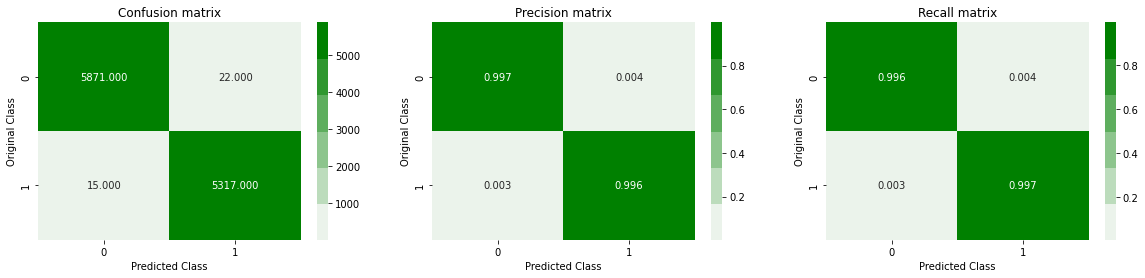

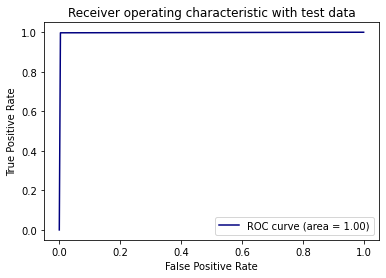

In [ ]:
# For countvectorizer
print("*"*10,"BAG-OF-WORD","*"*10)
BOW = bestparam_random_forest(X_train_count_vec, y_train, X_test_count_vec, y_test,'Random Forest','BAG OF WORDS', 'Yes')
print("\n\n")



********** TF-IDF **********
Fitting 3 folds for each of 24 candidates, totalling 72 fits



Best parameters
gridsearch:  {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}



Accuracy:  0.9964365256124722
Error:  0.06470675535876773




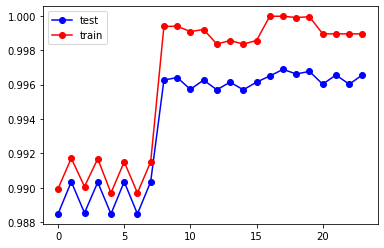

The train log loss is: 0.0014990668816479355
The test log loss is: 0.012586611806834217



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5893
           1       1.00      1.00      1.00      5332

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225




Total number of data points : 11225





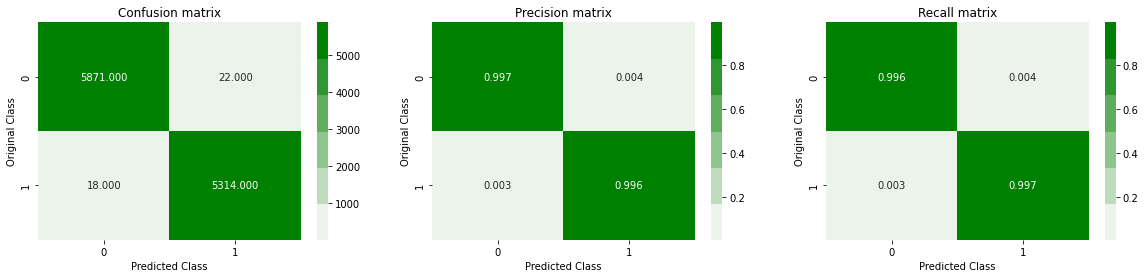

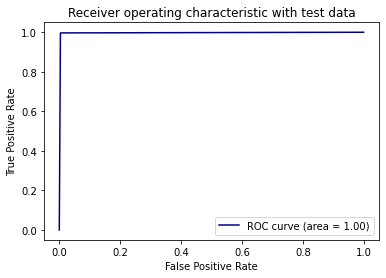

In [ ]:
# For tfidfvectorizer
print("*"*10,"TF-IDF","*"*10)
TF_IDF = bestparam_random_forest(X_train_tfidf_vec, y_train, X_test_tfidf_vec, y_test,'Random Forest','TF-IDF','Yes')
print("\n\n")


********** DOC2VEC **********
Fitting 3 folds for each of 24 candidates, totalling 72 fits



Best parameters
gridsearch:  {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}



Accuracy:  0.9716703786191537
Error:  0.18131071015773836




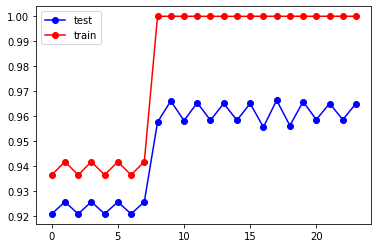

The train log loss is: 0.009770830709147332
The test log loss is: 0.07889410749023734



              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5893
           1       0.97      0.97      0.97      5332

    accuracy                           0.97     11225
   macro avg       0.97      0.97      0.97     11225
weighted avg       0.97      0.97      0.97     11225




Total number of data points : 11225





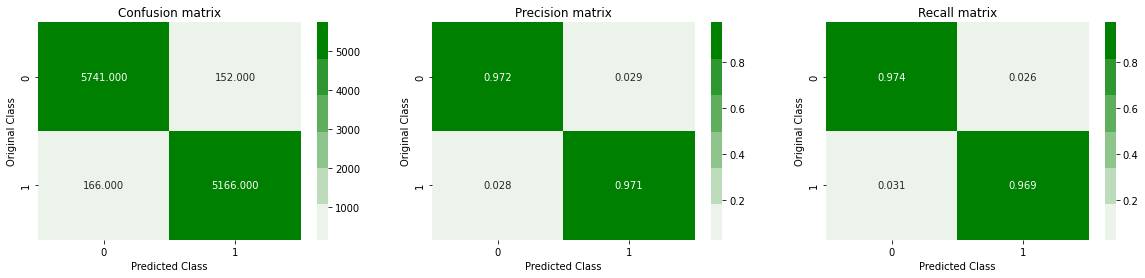

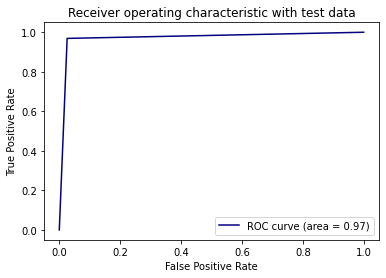

In [ ]:
# For Doc2vec
print("*"*10,"DOC2VEC","*"*10)
DOC2VEC = bestparam_random_forest(X_train_dbow_vec, y_train, X_test_dbow_vec, y_test,'Random Forest','DOC2VEC','Yes')

In [ ]:
#storing result to dataframe
dt = [BOW,TF_IDF,DOC2VEC]
df7 = pd.DataFrame(dt,columns=['Model','Technique','Hyperparameter-Tuning','Accuracy','Error'])
summary_df = summary_df.append(df7, ignore_index = True)
df7

,Model,Technique,Hyperparameter-Tuning,Accuracy,Error
0,Random Forest,BAG OF WORDS,Yes,0.996704,0.064015
1,Random Forest,TF-IDF,Yes,0.996437,0.064707
2,Random Forest,DOC2VEC,Yes,0.971670,0.181311


**XGBOOST**

In [ ]:
from xgboost import XGBClassifier

def xg_boost(x_train, Y_train, x_test, Y_test,model,technique,hyperparameter):
  data = []
  xg_boost = XGBClassifier()
  print(xg_boost.get_params())
  xg_boost.fit(x_train, Y_train)
  xg_boost_prediction = xg_boost.predict(x_test)

  Accuracy = accuracy_score(Y_test, xg_boost_prediction)
  print('Accuracy: ', Accuracy)

  err=-cross_val_score(xg_boost,x_test,Y_test,cv=10,scoring="neg_mean_squared_error",verbose=False).mean()
  Error = np.sqrt(err)
  print('Error: ',Error)
  print('\n')

  data.append(model)
  data.append(technique)
  data.append(hyperparameter)
  data.append(Accuracy)
  data.append(Error)

  print(classification_report(Y_test, xg_boost_prediction))

  pred = xg_boost.predict_proba(x_train)
  pred_t = xg_boost.predict_proba(x_test)
  print("*"*10,"LOG-LOSS","*"*10)
  print('log loss on train dataset : ', log_loss(Y_train, pred))
  print('log loss on test dataset : ', log_loss(Y_test, pred_t))
  print('\n\n')
  #confusion matrix
  plot_confusion_matrix(Y_test, xg_boost_prediction)
  print('\n\n')

  return data

********** BAG-OF-WORD **********
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
Accuracy:  0.9951002227171493
Error:  0.07249996421745766


              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5893
           1       0.99      1.00      0.99      5332

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225

********** LOG-LOSS **********
log loss on train dataset :  0.010578234722542726
log loss on test dataset :  0.01811446951715136





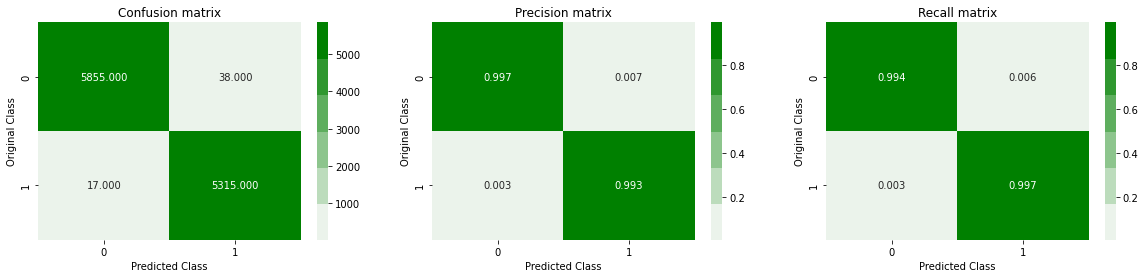







********** TF-IDF **********
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
Accuracy:  0.9955456570155902
Error:  0.07126058557719331


              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5893
           1       0.99      1.00      1.00      5332

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225

********** LOG-LOSS **********
log loss on train dataset :  0.009576318114068052
log loss on test dataset :  0.018499968874035922





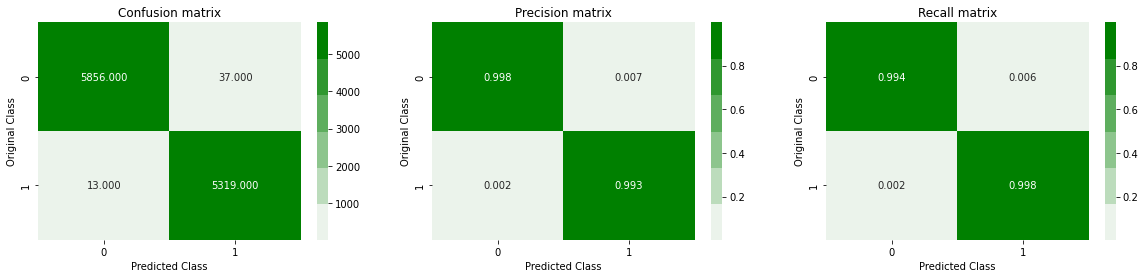







********** DOC2VEC **********
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
Accuracy:  0.9475278396436526
Error:  0.23728551246003912


              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5893
           1       0.95      0.94      0.94      5332

    accuracy                           0.95     11225
   macro avg       0.95      0.95      0.95     11225
weighted avg       0.95      0.95      0.95     11225

********** LOG-LOSS **********
log loss on train dataset :  0.20128541213794623
log loss on test dataset :  0.2263499192978133





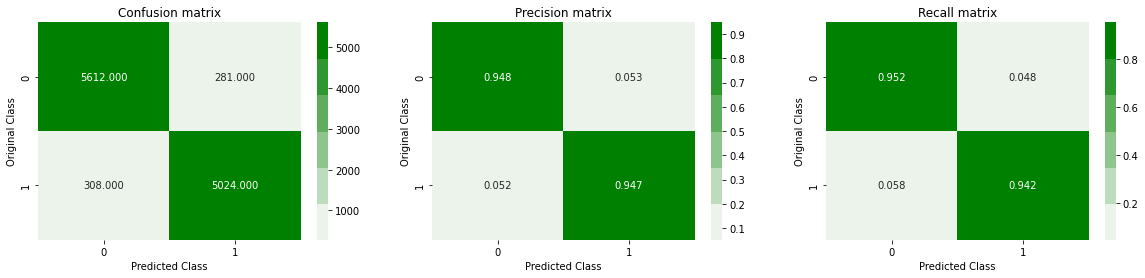

In [ ]:
# For countvectorizer
print("*"*10,"BAG-OF-WORD","*"*10)
BOW = xg_boost(X_train_count_vec, y_train, X_test_count_vec, y_test,'Xgboost','BAG OF WORDS', 'No')
print("\n\n")

# For tfidfvectorizer
print("*"*10,"TF-IDF","*"*10)
TF_IDF = xg_boost(X_train_tfidf_vec, y_train, X_test_tfidf_vec, y_test,'Xgboost','TF-IDF','No')
print("\n\n")

# For Doc2vec
print("*"*10,"DOC2VEC","*"*10)
DOC2VEC = xg_boost(X_train_dbow_vec, y_train, X_test_dbow_vec, y_test,'Xgboost','DOC2VEC','No')


In [ ]:
#storing result to dataframe
dt = [BOW,TF_IDF,DOC2VEC]
df8 = pd.DataFrame(dt,columns=['Model','Technique','Hyperparameter-Tuning','Accuracy','Error'])
summary_df = summary_df.append(df8, ignore_index = True)
df8

,Model,Technique,Hyperparameter-Tuning,Accuracy,Error
0,Xgboost,BAG OF WORDS,No,0.995100,0.072500
1,Xgboost,TF-IDF,No,0.995546,0.071261
2,Xgboost,DOC2VEC,No,0.947528,0.237286


In [ ]:
summary_df

,Model,Technique,Hyperparameter-Tuning,Accuracy,Error
0,Logestic Regression,BAG OF WORDS,No,0.994120,0.088034
1,Logestic Regression,TF-IDF,No,0.985835,0.143141
2,Logestic Regression,DOC2VEC,No,0.991091,0.100776
3,Logestic Regression,BAG OF WORDS,Yes,0.993942,0.089540
4,Logestic Regression,TF-IDF,Yes,0.990379,0.118263
5,Logestic Regression,DOC2VEC,Yes,0.991448,0.104253
6,Naive Bayes,BAG OF WORDS,No,0.901381,0.304242
7,Naive Bayes,TF-IDF,No,0.937550,0.248470
8,Naive Bayes,DOC2VEC,No,0.926414,0.271597
9,Decision Tree,BAG OF WORDS,No,0.993318,0.091996


In [ ]:
summary_df.to_pickle('/content/drive/MyDrive/Fake News/pickels/summary_model')

In [ ]:
summary_df = pd.read_pickle("/content/drive/MyDrive/Fake News/pickels/summary_model")
summary_df

,Model,Technique,Hyperparameter-Tuning,Accuracy,Error
0,Logestic Regression,BAG OF WORDS,No,0.994120,0.088034
1,Logestic Regression,TF-IDF,No,0.985835,0.143141
2,Logestic Regression,DOC2VEC,No,0.991091,0.100776
3,Logestic Regression,BAG OF WORDS,Yes,0.993942,0.089540
4,Logestic Regression,TF-IDF,Yes,0.990379,0.118263
5,Logestic Regression,DOC2VEC,Yes,0.991448,0.104253
6,Naive Bayes,BAG OF WORDS,No,0.901381,0.304242
7,Naive Bayes,TF-IDF,No,0.937550,0.248470
8,Naive Bayes,DOC2VEC,No,0.926414,0.271597
9,Decision Tree,BAG OF WORDS,No,0.993318,0.091996


### **Summarizing all models**

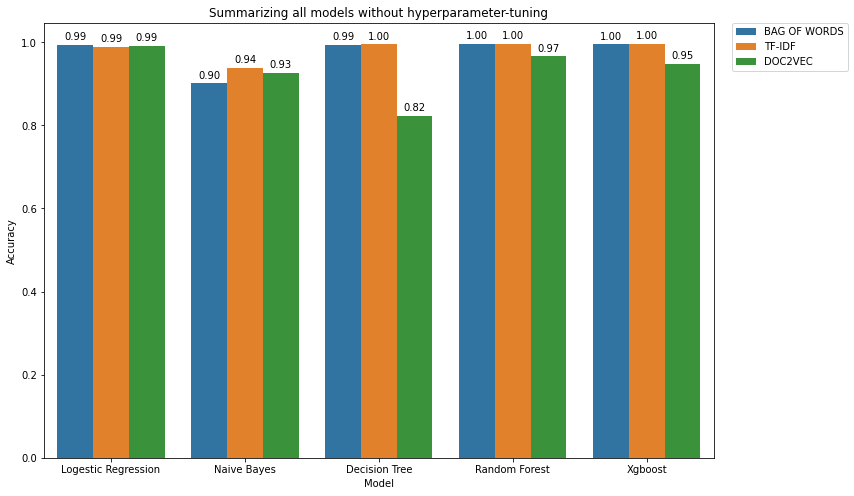

In [ ]:
#Models without Hyperparameter-tuning
plt.figure(figsize=(12,8))
import seaborn as sns
plots = sns.barplot(x = summary_df["Model"],
            y = summary_df["Accuracy"],
            hue = summary_df["Technique"],
            data = summary_df[summary_df["Hyperparameter-Tuning"] == 'No'],
            ci = 0)
for bar in plots.patches:
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
  plots.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha='center', va='center',
                  size=10, xytext=(0, 8),
                  textcoords='offset points')

plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.title("Summarizing all models without hyperparameter-tuning")
plt.xlabel("Model")
plt.ylabel("Accuracy")
# Show the plot
plt.show()

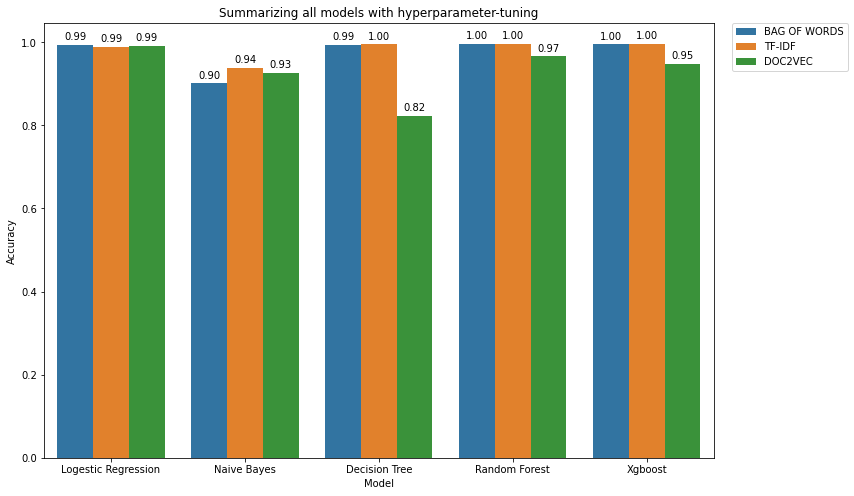

In [ ]:
#Models with Hyperparameter-tuning
plt.figure(figsize=(12,8))
import seaborn as sns
plots = sns.barplot(x = summary_df["Model"],
            y = summary_df["Accuracy"],
            hue = summary_df["Technique"],
            data = summary_df[summary_df["Hyperparameter-Tuning"] == 'Yes'],
            ci = 0)
for bar in plots.patches:
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
  plots.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha='center', va='center',
                  size=10, xytext=(0, 8),
                  textcoords='offset points')

plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.title("Summarizing all models with hyperparameter-tuning")
plt.xlabel("Model")
plt.ylabel("Accuracy")
# Show the plot
plt.show()

### **Final Model** - Logestic Regression(Bag of words)

Accuracy:  0.9941202672605791
Error:  0.08803387470408099


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5893
           1       0.99      0.99      0.99      5332

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

********** LOG-LOSS **********
log loss on train dataset :  0.0038478940278988934
log loss on test dataset :  0.029385641705048923


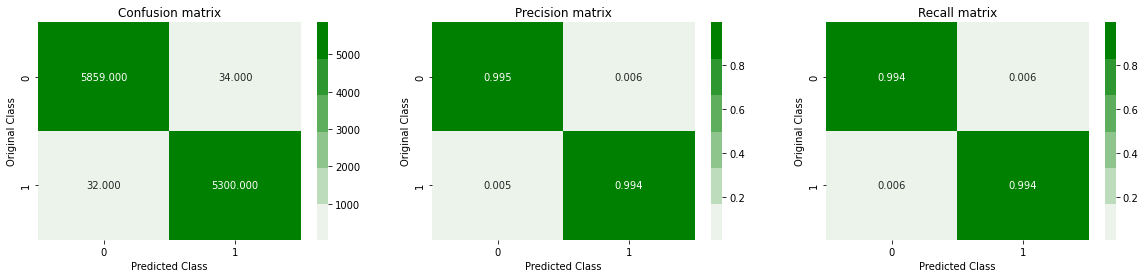

In [22]:
log_reg = LogisticRegression(max_iter = 300)
log_reg.fit(X_train_count_vec, y_train)
log_reg_prediction = log_reg.predict(X_test_count_vec)
Accuracy = accuracy_score(y_test, log_reg_prediction)
print('Accuracy: ', Accuracy)
err=-cross_val_score(log_reg,X_test_count_vec,y_test,cv=10,scoring="neg_mean_squared_error",verbose=False).mean()
Error = np.sqrt(err)
print('Error: ',Error)
print('\n')
print(classification_report(y_test, log_reg_prediction))
pred = log_reg.predict_proba(X_train_count_vec)
pred_t = log_reg.predict_proba(X_test_count_vec)
print("*"*10,"LOG-LOSS","*"*10)

print('log loss on train dataset : ', log_loss(y_train, pred))
print('log loss on test dataset : ', log_loss(y_test, pred_t))

#plot confusion matrix
plot_confusion_matrix(y_test, log_reg_prediction)

In [25]:
#saving model
import joblib
filename = '/content/drive/MyDrive/Fake News/pickels/Logistic_BOW_model.pkl'
joblib.dump(log_reg, filename)

['/content/drive/MyDrive/Fake News/pickels/Logistic_BOW_model.pkl']

In [26]:

# Load the model from the file
log_from_joblib = joblib.load('/content/drive/MyDrive/Fake News/pickels/Logistic_BOW_model.pkl')
 
# Use the loaded model to make predictions
logist_pred = log_from_joblib.predict(X_test_count_vec)

Accuracy = accuracy_score(y_test, logist_pred)
print('Accuracy: ', Accuracy)

Accuracy:  0.9941202672605791
